In [1]:
import numpy as np
import pandas as pd
import time
import yfinance as yf
from yahooquery import Screener
from yahooquery import Ticker  

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller


import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def get_companies():
    
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)
    sp500_df = table[0]
    sp500_symbols = sp500_df['Symbol'].tolist()
    tickers = Ticker(sp500_symbols)
    profiles = tickers.summary_profile
    profiles_df = pd.DataFrame(profiles).T.reset_index()
    profiles_df.rename(columns={'index': 'symbol'}, inplace=True)
    
    return profiles_df    

In [3]:
all_companies = get_companies()

In [4]:
all_companies

,symbol,address1,city,state,zip,country,phone,website,industry,industryKey,...,sector,sectorKey,sectorDisp,longBusinessSummary,fullTimeEmployees,companyOfficers,irWebsite,maxAge,address2,fax
0,MMM,3M Center,Saint Paul,MN,55144-1000,United States,651 733 1110,https://www.3m.com,Conglomerates,conglomerates,...,Industrials,industrials,Industrials,3M Company provides diversified technology ser...,85000,[],http://phx.corporate-ir.net/phoenix.zhtml?c=80...,86400,NaN,NaN
1,AOS,11270 West Park Place,Milwaukee,WI,53224-9508,United States,414 359 4000,https://www.aosmith.com,Specialty Industrial Machinery,specialty-industrial-machinery,...,Industrials,industrials,Industrials,A. O. Smith Corporation manufactures and marke...,12000,[],http://investor.shareholder.com/aosmith/,86400,Suite 170 PO Box 245008,NaN
2,ABT,100 Abbott Park Road,North Chicago,IL,60064-6400,United States,224 667 6100,https://www.abbott.com,Medical Devices,medical-devices,...,Healthcare,healthcare,Healthcare,"Abbott Laboratories, together with its subsidi...",114000,[],http://www.abbottinvestor.com/phoenix.zhtml?c=...,86400,Abbott Park,NaN
3,ABBV,1 North Waukegan Road,North Chicago,IL,60064-6400,United States,847 932 7900,https://www.abbvie.com,Drug Manufacturers - General,drug-manufacturers-general,...,Healthcare,healthcare,Healthcare,"AbbVie Inc. discovers, develops, manufactures,...",50000,[],NaN,86400,NaN,NaN
4,ACN,1 Grand Canal Square,Dublin,NaN,D02 P820,Ireland,353 1 646 2000,https://www.accenture.com,Information Technology Services,information-technology-services,...,Technology,technology,Technology,Accenture plc provides strategy and consulting...,774000,[],http://investor.accenture.com/phoenix.zhtml?c=...,86400,Grand Canal Harbour,353 1 646 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,300 Water Street SE,Washington,DC,20003,United States,202 869 9150,https://www.xylem.com,Specialty Industrial Machinery,specialty-industrial-machinery,...,Industrials,industrials,Industrials,"Xylem Inc., together with its subsidiaries, en...",23000,[],NaN,86400,Suite 200,NaN
499,YUM,1441 Gardiner Lane,Louisville,KY,40213,United States,502 874 8300,https://www.yum.com,Restaurants,restaurants,...,Consumer Cyclical,consumer-cyclical,Consumer Cyclical,"Yum! Brands, Inc., together with its subsidiar...",35000,[],http://www.yum.com/investors/,86400,NaN,NaN
500,ZBRA,3 Overlook Point,Lincolnshire,IL,60069,United States,847 634 6700,https://www.zebra.com,Communication Equipment,communication-equipment,...,Technology,technology,Technology,"Zebra Technologies Corporation, together with ...",9750,[],http://www.zebra.com/id/zebra/na/en/index/abou...,86400,NaN,NaN
501,ZBH,345 East Main Street,Warsaw,IN,46580,United States,574 373 3333,https://www.zimmerbiomet.com,Medical Devices,medical-devices,...,Healthcare,healthcare,Healthcare,"Zimmer Biomet Holdings, Inc., together with it...",18000,[],http://investor.zimmer.com/,86400,NaN,NaN


In [5]:
unique_sectors_list = all_companies['sector'].unique().tolist()

In [6]:
for sector in unique_sectors_list:
    if sector != 'No fundamentals data found for any of the summaryTypes=summaryProfile':
        print(sector)

Industrials
Healthcare
Technology
Utilities
Financial Services
Basic Materials
Consumer Cyclical
Real Estate
Communication Services
Consumer Defensive
Energy


In [34]:
def filter_companies(companies, sector, marketCap_thresh=2_000_000_000,averageVolume_thresh=5_000_000, start_date="2018-11-16", end_date="2022-11-16"):
    
    sector_companies = companies[companies['sector'] == sector]
    sector_symbols = sector_companies['symbol'].tolist()

    filtered_symbols = []
    for symbol in sector_symbols:
        try:
            # Fetch ticker info with error handling
            ticker_info = yf.Ticker(symbol).info

            # Check if data exists and if marketCap and averageVolume thresholds are met
            market_cap = ticker_info.get("marketCap")
            average_volume = ticker_info.get("averageVolume")
            if market_cap is not None and market_cap > marketCap_thresh and \
                    average_volume is not None and average_volume > averageVolume_thresh:
                filtered_symbols.append(symbol)
        except Exception as e:
            # Print or log error message for the symbol
            print(f"Error fetching data for {symbol}: {e}")
        # Add delay to avoid rate limiting
        time.sleep(0.5)

    # Initialize an empty DataFrame to store the historical closing prices
    filtered_symbols_df = pd.DataFrame()

    # Fetch historical data for each filtered symbol
    for symbol in filtered_symbols:
        try:
            ticker = yf.Ticker(symbol)
            historical_data = ticker.history(start=start_date, end=end_date)
            # Store the 'Close' prices in the DataFrame
            filtered_symbols_df[symbol] = historical_data['Close']
        except Exception as e:
            # Print or log error message for the symbol if historical data cannot be fetched
            print(f"Error fetching historical data for {symbol}: {e}")
        # Add delay to avoid rate limiting
        time.sleep(0.05)
        
    return filtered_symbols_df

In [17]:
def find_cointegrated_pairs(combined_df, p_value_threshold=0.07, min_data_points_threshold=100):
    """
    Finds and prints pairs of stock symbols that are cointegrated.
    
    Parameters:
    - combined_df: DataFrame containing historical daily prices with symbols as columns.
    - p_value_threshold: The significance level for cointegration (default is 0.02).
    - min_data_points_threshold: The minimum number of data points required to test cointegration.
    
    Returns:
    - pairs_sorted: List of tuples containing cointegrated pairs sorted by p-value.
    """
    
    symbols = combined_df.columns
    n = len(symbols)

    pairs = []

    # Loop through symbols and perform the cointegration test for each unique pair
    for i in range(n):
        for j in range(i + 1, n):
            symbol_1 = symbols[i]
            symbol_2 = symbols[j]

            series1 = combined_df[symbol_1]
            series2 = combined_df[symbol_2]
            
            # Combine series and drop NaN values
            combined_pair = pd.concat([series1, series2], axis=1).dropna()
            data_points = len(combined_pair)

            # Debug: Print the length of combined data
            print(f"Testing pair {symbol_1} and {symbol_2}, Number of data points: {data_points}")

            # Check if there are enough data points
            if data_points >= min_data_points_threshold:
                # Perform the cointegration test
                coint_t, p_value, _ = coint(combined_pair.iloc[:, 0], combined_pair.iloc[:, 1])

                # Check if the p-value is below the threshold
                if p_value < p_value_threshold:
                    print(f"{symbol_1} and {symbol_2} are likely cointegrated (p-value: {p_value:.4f})")
                    pairs.append((symbol_1, symbol_2, p_value))
                    # Debug: Confirm pairs being appended correctly
                    print(f"Current pairs in function after appending: {pairs}")

    # Debug: Confirm list of pairs before sorting
    print(f"Pairs before sorting: {pairs}")

    # Sort pairs by p-value
    pairs_sorted = sorted(pairs, key=lambda x: x[2])

    # Debug: Print final sorted pairs before returning
    print(f"Final sorted pairs in function: {pairs_sorted}")

    return pairs_sorted


In [19]:
all_pairs_data = []  # Initialize once before the loop

for sector in unique_sectors_list:
    if sector != 'No fundamentals data found for any of the summaryTypes=summaryProfile':
        filtered_symbols_df = filter_companies(all_companies, sector)
        print(f"Processing sector: {sector}, Number of companies: {len(filtered_symbols_df.columns)}")

        if len(filtered_symbols_df.columns) < 2:
            print(f"Not enough companies in sector {sector} for cointegration testing.")
            continue

        # Find cointegrated pairs for the current sector
        pairs_data = find_cointegrated_pairs(filtered_symbols_df, p_value_threshold=0.02, min_data_points_threshold=100)

        # Debug: Print pairs_data being returned for the current sector
        print(f"Cointegrated pairs for sector {sector}: {pairs_data}")

        # Accumulate the pairs data across all sectors
        all_pairs_data.extend(pairs_data)  # Ensure correct accumulation

        # Debug: Print the current state of all_pairs_data after each sector
        print(f"Accumulated pairs so far: {all_pairs_data}")

# Final accumulated result
print("\nAll Cointegrated Pairs Across Sectors:")
for pair in all_pairs_data:
    print(pair)


Processing sector: Industrials, Number of companies: 6
Testing pair BA and CSX, Number of data points: 1006
Testing pair BA and DAL, Number of data points: 1006
Testing pair BA and RTX, Number of data points: 1006
Testing pair BA and LUV, Number of data points: 1006
Testing pair BA and UAL, Number of data points: 1006
BA and UAL are likely cointegrated (p-value: 0.0123)
Current pairs in function after appending: [('BA', 'UAL', 0.012332123370913132)]
Testing pair CSX and DAL, Number of data points: 1006
Testing pair CSX and RTX, Number of data points: 1006
Testing pair CSX and LUV, Number of data points: 1006
Testing pair CSX and UAL, Number of data points: 1006
Testing pair DAL and RTX, Number of data points: 1006
Testing pair DAL and LUV, Number of data points: 1006
Testing pair DAL and UAL, Number of data points: 1006
Testing pair RTX and LUV, Number of data points: 1006
Testing pair RTX and UAL, Number of data points: 1006
Testing pair LUV and UAL, Number of data points: 1006
Pairs 

$KVUE: possibly delisted; no price data found  (1d 2018-11-16 -> 2022-11-16) (Yahoo error = "Data doesn't exist for startDate = 1542344400, endDate = 1668574800")


Processing sector: Consumer Defensive, Number of companies: 13
Testing pair MO and KO, Number of data points: 1006
Testing pair MO and DG, Number of data points: 1006
Testing pair MO and DLTR, Number of data points: 1006
Testing pair MO and KVUE, Number of data points: 0
Testing pair MO and KDP, Number of data points: 1006
Testing pair MO and KHC, Number of data points: 1006
Testing pair MO and MDLZ, Number of data points: 1006
Testing pair MO and MNST, Number of data points: 1006
Testing pair MO and PEP, Number of data points: 1006
Testing pair MO and PM, Number of data points: 1006
Testing pair MO and PG, Number of data points: 1006
Testing pair MO and WMT, Number of data points: 1006
Testing pair KO and DG, Number of data points: 1006
Testing pair KO and DLTR, Number of data points: 1006
Testing pair KO and KVUE, Number of data points: 0
Testing pair KO and KDP, Number of data points: 1006
Testing pair KO and KHC, Number of data points: 1006
Testing pair KO and MDLZ, Number of data 

In [20]:
sorted_pairs = sorted(all_pairs_data, key=lambda x: x[2])
sorted_pairs

[('KDP', 'PM', 0.0003882726622174265),
 ('PCG', 'VST', 0.0033683272499536398),
 ('APA', 'MRO', 0.0037492112436776294),
 ('MCHP', 'TXN', 0.004866022085177233),
 ('ABBV', 'CNC', 0.007582183936547386),
 ('LRCX', 'MCHP', 0.0101236952996349),
 ('AMAT', 'ORCL', 0.011063138830888717),
 ('CNC', 'CVS', 0.01175631565637868),
 ('AVGO', 'HPQ', 0.011923914144777725),
 ('BA', 'UAL', 0.012332123370913132),
 ('MCHP', 'ORCL', 0.012498442037330998),
 ('CMCSA', 'META', 0.013069655784001785),
 ('BKR', 'HAL', 0.014960439371984092),
 ('JNJ', 'VTRS', 0.016116965094842797),
 ('APA', 'XOM', 0.016152009387094688),
 ('MDLZ', 'PM', 0.018132236791800264),
 ('SCHW', 'RF', 0.018998402990664826)]

In [21]:
for tup in sorted_pairs:
    
    ticker_1 = yf.Ticker(tup[0])
    ticker_2 = yf.Ticker(tup[1])
    data_1 = ticker_1.history(start="2022-11-16", end="2024-11-16")["Close"]
    data_2 = ticker_2.history(start="2022-11-16", end="2024-11-16")["Close"]

    coint_t, p_value, _ = coint(data_1, data_2)
    if p_value < 0.05:
        print(f"The pair: {tup[0]}, {tup[1]} are validated with p-value = {p_value}")
    else:
        print(f"The pair: {tup[0]}, {tup[1]} are NOT validated with p-value = {p_value}")

The pair: KDP, PM are NOT validated with p-value = 0.4500183757415706
The pair: PCG, VST are NOT validated with p-value = 0.05864989534219846
The pair: APA, MRO are NOT validated with p-value = 0.7376888436818415
The pair: MCHP, TXN are NOT validated with p-value = 0.7320379363976766
The pair: ABBV, CNC are NOT validated with p-value = 0.8457336902585557
The pair: LRCX, MCHP are NOT validated with p-value = 0.8118318048557529
The pair: AMAT, ORCL are NOT validated with p-value = 0.9683098518349559
The pair: CNC, CVS are NOT validated with p-value = 0.3925400714725553
The pair: AVGO, HPQ are NOT validated with p-value = 0.20348298800152287
The pair: BA, UAL are NOT validated with p-value = 0.36981639971452007
The pair: MCHP, ORCL are NOT validated with p-value = 0.6410310820280237
The pair: CMCSA, META are NOT validated with p-value = 0.42700391109096797
The pair: BKR, HAL are NOT validated with p-value = 0.9761076716594945
The pair: JNJ, VTRS are NOT validated with p-value = 0.24884500

In [ ]:
def filter_all_companies(companies, marketCap_thresh=2_000_000_000, averageVolume_thresh=5_000_000, start_date="2018-11-16", end_date="2022-11-16"):
    """
    Filters companies by market cap and average volume.
    Fetches historical closing prices for each filtered symbol.

    Parameters:
    - companies: DataFrame containing company data, including 'sector' and 'symbol'.
    - marketCap_thresh: Minimum market capitalization (default is 2 billion).
    - averageVolume_thresh: Minimum average volume (default is 5 million).
    - start_date: Start date for historical data.
    - end_date: End date for historical data.
    """
    # Get the list of all company symbols
    all_symbols = companies['symbol'].tolist()

    filtered_symbols = []
    for symbol in all_symbols:
        try:
            # Fetch ticker info with error handling
            ticker_info = yf.Ticker(symbol).info

            # Check if data exists and if marketCap and averageVolume thresholds are met
            market_cap = ticker_info.get("marketCap")
            average_volume = ticker_info.get("averageVolume")
            if market_cap is not None and market_cap > marketCap_thresh and \
                    average_volume is not None and average_volume > averageVolume_thresh:
                filtered_symbols.append(symbol)
        except Exception as e:
            # Print or log error message for the symbol
            print(f"Error fetching data for {symbol}: {e}")
        # Add delay to avoid rate limiting
        time.sleep(0.5)

    # Initialize an empty DataFrame to store the historical closing prices
    filtered_symbols_df = pd.DataFrame()

    # Fetch historical data for each filtered symbol
    for symbol in filtered_symbols:
        try:
            ticker = yf.Ticker(symbol)
            historical_data = ticker.history(start=start_date, end=end_date)
            # Store the 'Close' prices in the DataFrame
            filtered_symbols_df[symbol] = historical_data['Close']
        except Exception as e:
            # Print or log error message for the symbol if historical data cannot be fetched
            print(f"Error fetching historical data for {symbol}: {e}")
        # Add delay to avoid rate limiting
        time.sleep(0.05)

    return filtered_symbols_df


In [ ]:
all_pairs_2 = []  # Initialize once before the loop

filtered_symbols_df_2 = filter_all_companies(all_companies)

pairs_data_2 = find_cointegrated_pairs(filtered_symbols_df_2, p_value_threshold=0.02, min_data_points_threshold=100)

all_pairs_data_2.extend(pairs_data_2)  

# Final accumulated result
print("\nAll Cointegrated Pairs Across Sectors:")
for pair in all_pairs_data_2:
    print(pair)

In [31]:
pairs_data_2

[('CSX', 'DELL', 6.320426653403685e-05),
 ('CSX', 'FCX', 0.0003486068746788512),
 ('KDP', 'PM', 0.00038827372364038564),
 ('MDLZ', 'VTRS', 0.0007694119226627506),
 ('HPE', 'HST', 0.000859558553769059),
 ('BA', 'NCLH', 0.0009205671356514296),
 ('BA', 'CCL', 0.0009422106011086133),
 ('AAPL', 'NEE', 0.0010378636587145538),
 ('PCG', 'V', 0.001212435522082543),
 ('PCG', 'VZ', 0.0013732981427975774),
 ('PCG', 'WMT', 0.0014712001505169609),
 ('PARA', 'LUV', 0.0017304572646444853),
 ('BSX', 'USB', 0.0018044000202292801),
 ('VTRS', 'WMT', 0.0020212525718855223),
 ('BSX', 'WFC', 0.0020906119278352917),
 ('PLTR', 'PYPL', 0.002127170515512428),
 ('PCG', 'PG', 0.00214947511666389),
 ('AMCR', 'JNJ', 0.0021987027342723776),
 ('NCLH', 'UAL', 0.002349387176779187),
 ('KDP', 'ON', 0.0024530309121871536),
 ('DVN', 'DLTR', 0.0024550663482402037),
 ('V', 'WMT', 0.002646110511877865),
 ('PCG', 'CRM', 0.0027089848513459254),
 ('DG', 'VTRS', 0.0029242253311637647),
 ('DOC', 'USB', 0.0029692543209662086),
 ('P

In [39]:
validated_pairs = []

for tup in pairs_data_2:
    try:
        ticker_1 = yf.Ticker(tup[0])
        ticker_2 = yf.Ticker(tup[1])
        data_1 = ticker_1.history(start="2022-11-16", end="2024-11-16")["Close"]
        data_2 = ticker_2.history(start="2022-11-16", end="2024-11-16")["Close"]

        # Perform the cointegration test
        coint_t, p_value, _ = coint(data_1, data_2)

        # If p-value is below the threshold, add to validated pairs list and print
        if p_value < 0.05:
            print(f"The pair: {tup[0]}, {tup[1]} are validated with p-value = {p_value:.4f}")
            validated_pairs.append((tup[0], tup[1], p_value))

    except Exception as e:
        print(f"Error processing pair {tup[0]}, {tup[1]}: {e}")

# Sort the validated pairs by p-value in ascending order
validated_pairs_sorted = sorted(validated_pairs, key=lambda x: x[2])

# Optionally, print the sorted list of validated pairs
print("\nValidated Pairs in Ascending Order of p-value:")
for pair in validated_pairs_sorted:
    print(f"The pair: {pair[0]}, {pair[1]} with p-value = {pair[2]:.4f}")


The pair: PCG, WMT are validated with p-value = 0.0187
The pair: PCG, PM are validated with p-value = 0.0271
The pair: DLTR, WMB are validated with p-value = 0.0496
The pair: PCG, WMB are validated with p-value = 0.0245
The pair: AMCR, KDP are validated with p-value = 0.0153
The pair: MRK, SMCI are validated with p-value = 0.0155
The pair: PARA, UBER are validated with p-value = 0.0487
The pair: BSX, JPM are validated with p-value = 0.0137
The pair: GOOG, DELL are validated with p-value = 0.0326
The pair: GOOGL, DELL are validated with p-value = 0.0332
The pair: CNP, SLB are validated with p-value = 0.0336
The pair: F, KEY are validated with p-value = 0.0073

Validated Pairs in Ascending Order of p-value:
The pair: F, KEY with p-value = 0.0073
The pair: BSX, JPM with p-value = 0.0137
The pair: AMCR, KDP with p-value = 0.0153
The pair: MRK, SMCI with p-value = 0.0155
The pair: PCG, WMT with p-value = 0.0187
The pair: PCG, WMB with p-value = 0.0245
The pair: PCG, PM with p-value = 0.0271

In [41]:
validated_pairs_sorted

[('F', 'KEY', 0.007327074933705752),
 ('BSX', 'JPM', 0.01370488079528191),
 ('AMCR', 'KDP', 0.015296240057055842),
 ('MRK', 'SMCI', 0.015514296239371563),
 ('PCG', 'WMT', 0.018724538208109123),
 ('PCG', 'WMB', 0.024505125968078544),
 ('PCG', 'PM', 0.02709581643216537),
 ('GOOG', 'DELL', 0.03257280256268849),
 ('GOOGL', 'DELL', 0.033177522010561004),
 ('CNP', 'SLB', 0.03361669830949882),
 ('PARA', 'UBER', 0.04869075391431782),
 ('DLTR', 'WMB', 0.04961136995168697)]

Linear regression for pair: F and KEY
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     3486.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          9.10e-285
Time:                        17:35:43   Log-Likelihood:                -1428.3
No. Observations:                 755   AIC:                             2861.
Df Residuals:                     753   BIC:                             2870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

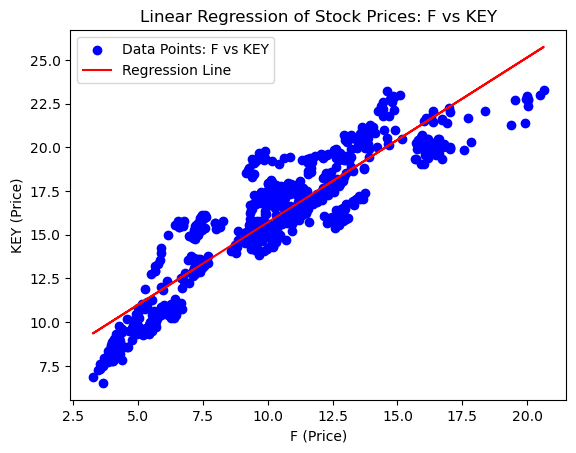

Linear regression for pair: BSX and JPM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     601.9
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           3.90e-98
Time:                        17:35:44   Log-Likelihood:                -3215.9
No. Observations:                 755   AIC:                             6436.
Df Residuals:                     753   BIC:                             6445.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

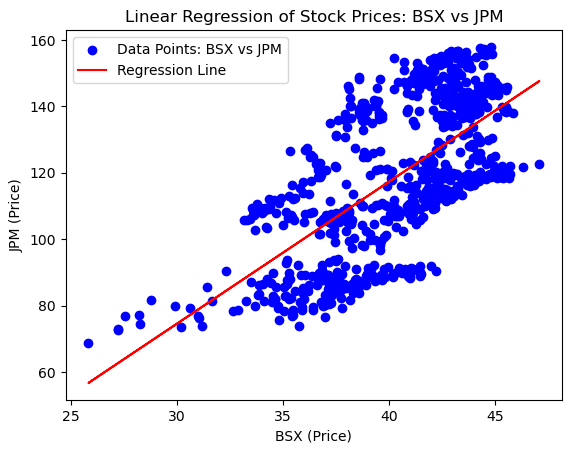

Linear regression for pair: AMCR and KDP
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     2208.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          4.17e-226
Time:                        17:35:44   Log-Likelihood:                -1653.0
No. Observations:                 755   AIC:                             3310.
Df Residuals:                     753   BIC:                             3319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

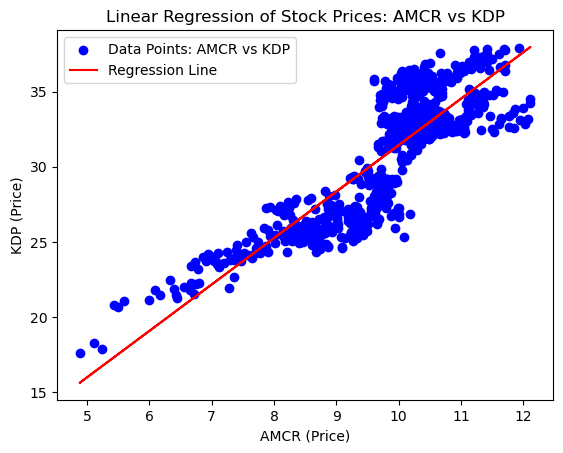

Linear regression for pair: MRK and SMCI
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     1104.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          9.63e-150
Time:                        17:35:44   Log-Likelihood:                -879.38
No. Observations:                 755   AIC:                             1763.
Df Residuals:                     753   BIC:                             1772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

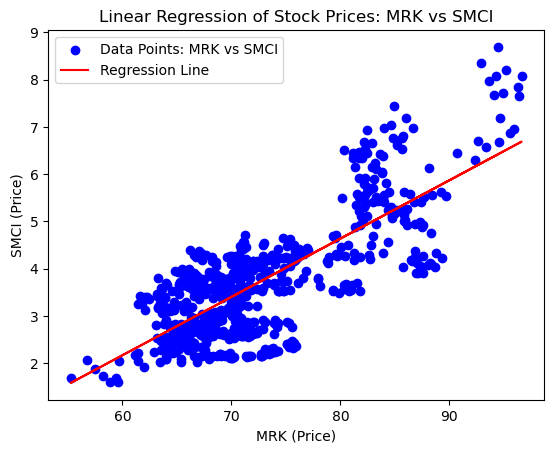

Linear regression for pair: PCG and WMT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2927
Date:                Sat, 16 Nov 2024   Prob (F-statistic):              0.589
Time:                        17:35:45   Log-Likelihood:                -2070.2
No. Observations:                 755   AIC:                             4144.
Df Residuals:                     753   BIC:                             4154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

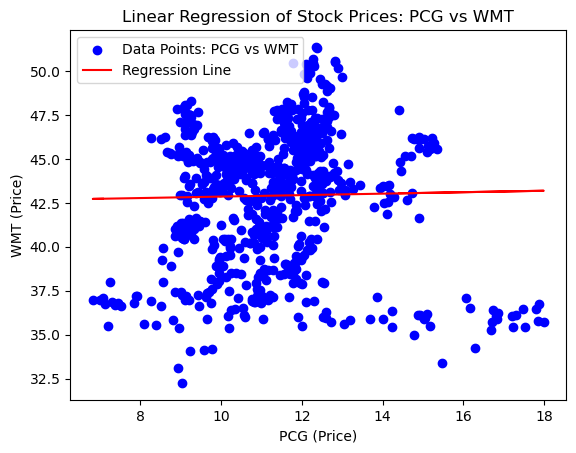

Linear regression for pair: PCG and WMB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     65.52
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           2.30e-15
Time:                        17:35:45   Log-Likelihood:                -2356.4
No. Observations:                 755   AIC:                             4717.
Df Residuals:                     753   BIC:                             4726.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

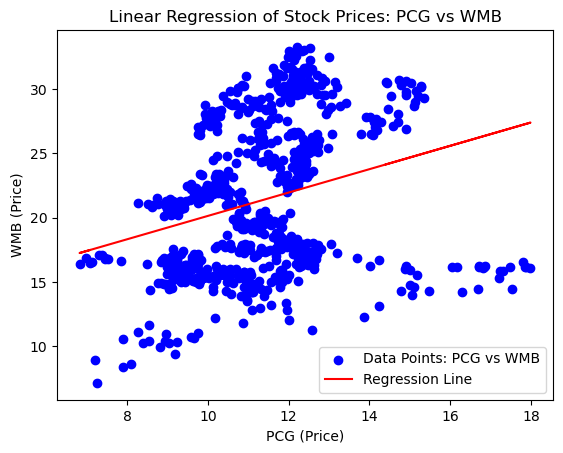

Linear regression for pair: PCG and PM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     21.84
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           3.52e-06
Time:                        17:35:45   Log-Likelihood:                -2899.1
No. Observations:                 755   AIC:                             5802.
Df Residuals:                     753   BIC:                             5811.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

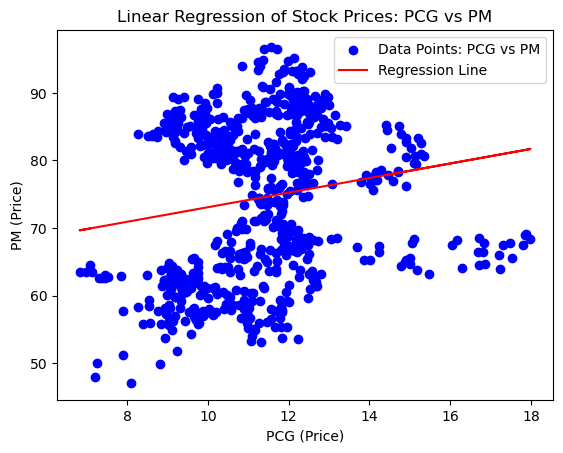

Linear regression for pair: GOOG and DELL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     7850.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:35:46   Log-Likelihood:                -1956.1
No. Observations:                 755   AIC:                             3916.
Df Residuals:                     753   BIC:                             3926.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

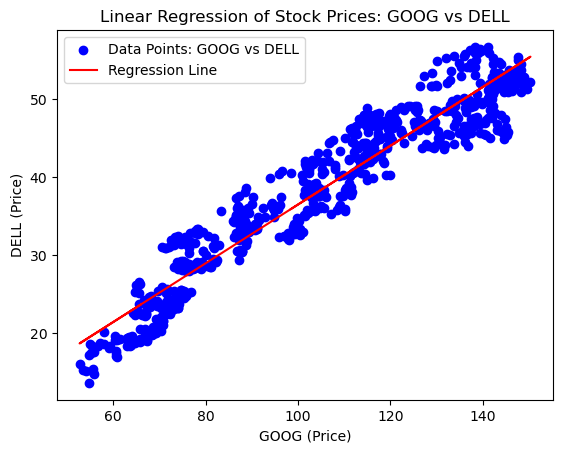

Linear regression for pair: GOOGL and DELL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     7785.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:35:46   Log-Likelihood:                -1959.0
No. Observations:                 755   AIC:                             3922.
Df Residuals:                     753   BIC:                             3931.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

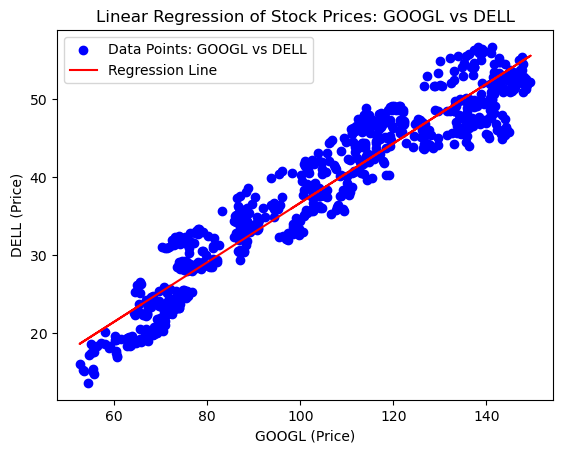

Linear regression for pair: CNP and SLB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     2149.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          8.94e-223
Time:                        17:35:46   Log-Likelihood:                -2226.9
No. Observations:                 755   AIC:                             4458.
Df Residuals:                     753   BIC:                             4467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

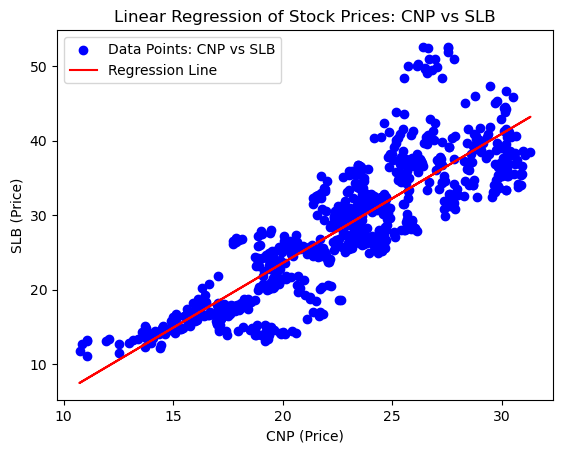

Linear regression for pair: PARA and UBER
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     752.3
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          2.26e-115
Time:                        17:35:46   Log-Likelihood:                -2569.0
No. Observations:                 755   AIC:                             5142.
Df Residuals:                     753   BIC:                             5151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

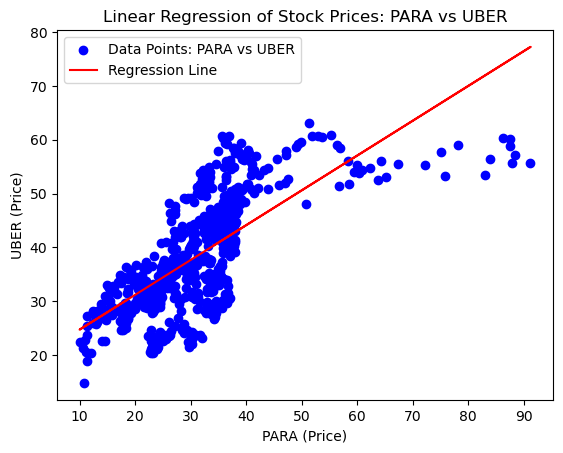

Linear regression for pair: DLTR and WMB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     3120.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          5.47e-270
Time:                        17:35:47   Log-Likelihood:                -1769.6
No. Observations:                 755   AIC:                             3543.
Df Residuals:                     753   BIC:                             3553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

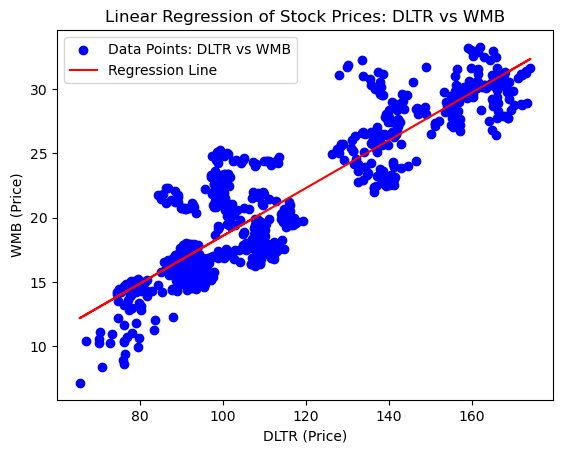

In [47]:
# Iterate through the validated pairs to perform linear regression
for tup in validated_pairs_sorted:
    try:
        # Fetch historical closing prices for the validated pair
        ticker_1 = yf.Ticker(tup[0])
        ticker_2 = yf.Ticker(tup[1])
        x_1 = ticker_1.history(start="2019-11-16", end="2022-11-16")["Close"]
        x_2 = ticker_2.history(start="2019-11-16", end="2022-11-16")["Close"]

        # Drop NaN values to align both series
        combined_data = pd.concat([x_1, x_2], axis=1).dropna()
        x_1 = combined_data.iloc[:, 0]
        x_2 = combined_data.iloc[:, 1]

        # Ensure that x_1 and x_2 are numpy arrays
        x_1 = np.array(x_1)
        x_2 = np.array(x_2)

        # Add a constant to x_1 for the intercept term
        x_1_with_const = sm.add_constant(x_1)

        # Perform linear regression
        model = sm.OLS(x_2, x_1_with_const)
        results = model.fit()

        # Extract the slope (b) from the regression results
        b = results.params[1]

        # Print the summary of the regression and the value of b
        print(f"Linear regression for pair: {tup[0]} and {tup[1]}")
        print(results.summary())
        print(f"Slope (b) of the regression: {b}")

        # Plot the results
        plt.scatter(x_1, x_2, color='blue', label=f'Data Points: {tup[0]} vs {tup[1]}')
        plt.plot(x_1, results.predict(x_1_with_const), color='red', label='Regression Line')
        plt.xlabel(f'{tup[0]} (Price)')
        plt.ylabel(f'{tup[1]} (Price)')
        plt.title(f'Linear Regression of Stock Prices: {tup[0]} vs {tup[1]}')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error processing pair {tup[0]}, {tup[1]}: {e}")
